# Analyze Tempearture Evolution

This notebook plots the time series of daily maximum temperature by BA.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from datetime import timedelta


## Set the Directory Structure

In [49]:
# Identify the data input and output directories:
ba_weather_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_to_tell_data/'
ics_weather_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/Interconnection_Meteorology_Time_Series/'
ba_mapping_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/'
output_dir = '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/BA_Min_Max_Temperature_Time_Series/'
image_output_dir = '/Users/burl878/Documents/Code/code_repos/heat_wave_load_visualization/plots/'


## Process the Historical Daily Minimum and Maximum Temperature Time Series


In [96]:
# Define a function to process the daily maximum and minimum temperature time series:
def process_daily_min_max_time_series(ba_weather_dir: str, ics_weather_dir: str, output_dir: str, ics_to_process: str):
    
    # Read in the BA-to-Interconnection mapping file:
    ba_df = pd.read_csv((ba_mapping_dir + 'BA_to_Interconnection_Mapping.csv'))
 
    # Subset to just the interconnection you want to process:
    ba_list = ba_df['BA_Code'].loc[ba_df['Interconnection'] == ics_to_process].unique()

    # Loop over the list of BAs in the interconnection:
    for i in range(len(ba_list)):
        
        # Loop over the years from the 1980 to 2022:
        for year in range(1980,2023,1):
            if year <= 2019:
               # Create the filename for the given BA and year combination:
               filename = (ba_weather_dir + 'historic/' + ba_list[i] + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv')
            else:
               # Create the filename for the given BA and year combination:
               filename = (ba_weather_dir + 'historic_2020_2022/' + ba_list[i] + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv') 
    
            # Read in the .csv file:
            met_df = pd.read_csv(filename)
    
            # Set the time variable as an index:
            met_df.index = pd.to_datetime(met_df['Time_UTC'])
        
            # Convert the temperature from Kelvin to Fahrenheit:
            met_df['T2'] = (1.8 * (met_df['T2'] - 273)) + 32
    
            # Compute the daily minimum and maximum temperature using resampling:
            temp_df = met_df.resample('D')['T2'].agg(['min', 'max']).reset_index()
        
            # Rename the variables for consistency:
            temp_df.rename(columns={'Time_UTC': 'Day', 'min': 'T2_Min', 'max': 'T2_Max'}, inplace=True)
        
            # Round off the min and max temperature variables:
            temp_df['T2_Min'] = temp_df['T2_Min'].round(2)
            temp_df['T2_Max'] = temp_df['T2_Max'].round(2)
        
            # Add a column with the year values to be used in grouping:
            temp_df['Year'] = temp_df['Day'].dt.strftime('%Y')
        
            # Set the day value as a datetime variable:
            temp_df['Day'] = pd.to_datetime(temp_df['Day'])
        
            # Compute the day of the year to be used in plotting:
            temp_df['Day_of_Year'] = temp_df['Day'].dt.dayofyear
        
            # Add in the BA code: 
            temp_df['BA'] = ba_list[i]
            
            # Reorder some of the variables:
            temp_df = temp_df[['BA', 'Day', 'Year', 'Day_of_Year', 'T2_Min', 'T2_Max']].copy()
        
            # Aggregate the output into a new dataframe:
            if year == 1980:
               ba_output_df = temp_df
            else:
               ba_output_df = pd.concat([ba_output_df, temp_df])
    
        # Aggregate the output into a new dataframe:
        if i == 0:
           ics_output_df = ba_output_df
        else:
           ics_output_df = pd.concat([ics_output_df, ba_output_df])
    
    # Loop over the years from the 1980 to 2022:
    for year in range(1980,2023,1):
                   
        # Read in the .csv file:
        met_df = pd.read_csv((ics_weather_dir + 'Interconnection_Meteorology_' + str(year) + '.csv'))
        
        # Subset to just the interconnection you want to process:
        met_df = met_df.loc[met_df['Interconnection'] == ics_to_process]
        
        # Set the time variable as an index:
        met_df.index = pd.to_datetime(met_df['Time_UTC'])
        
        # Convert the temperature from Kelvin to Fahrenheit:
        met_df['T2'] = (1.8 * (met_df['T2'] - 273)) + 32
    
        # Compute the daily minimum and maximum temperature using resampling:
        temp_df = met_df.resample('D')['T2'].agg(['min', 'max']).reset_index()
        
        # Rename the variables for consistency:
        temp_df.rename(columns={'Time_UTC': 'Day', 'min': 'T2_Min', 'max': 'T2_Max'}, inplace=True)
        
        # Round off the min and max temperature variables:
        temp_df['T2_Min'] = temp_df['T2_Min'].round(2)
        temp_df['T2_Max'] = temp_df['T2_Max'].round(2)
        
        # Add a column with the year values to be used in grouping:
        temp_df['Year'] = temp_df['Day'].dt.strftime('%Y')
        
        # Set the day value as a datetime variable:
        temp_df['Day'] = pd.to_datetime(temp_df['Day'])
        
        # Compute the day of the year to be used in plotting:
        temp_df['Day_of_Year'] = temp_df['Day'].dt.dayofyear
        
        # Add in the BA code: 
        temp_df['BA'] = ics_to_process
            
        # Reorder some of the variables:
        temp_df = temp_df[['BA', 'Day', 'Year', 'Day_of_Year', 'T2_Min', 'T2_Max']].copy()
    
        # Aggregate the output into a new dataframe:
        if year == 1980:
           ics_df = temp_df
        else:
           ics_df = pd.concat([ics_df, temp_df])
           
    # Concatenate the two primary dfs:
    ics_output_df = pd.concat([ics_output_df, ics_df])
    
    # Write out the dataframe to a .csv file:
    ics_output_df.to_csv((os.path.join(output_dir + ics_to_process + '_Min_Max_Temperature_1981_to_2019.csv')), sep=',', index=False)
    
    return ics_output_df 


In [99]:
ics_output_df = process_daily_min_max_time_series(ba_weather_dir = ba_weather_dir, 
                                                  ics_weather_dir = ics_weather_dir, 
                                                  output_dir = output_dir, 
                                                  ics_to_process = 'EIC')

ics_output_df


,BA,Day,Year,Day_of_Year,T2_Min,T2_Max
0,AEC,1980-01-01,1980,1,39.20,50.23
1,AEC,1980-01-02,1980,2,35.10,55.80
2,AEC,1980-01-03,1980,3,39.70,55.92
3,AEC,1980-01-04,1980,4,44.22,52.66
4,AEC,1980-01-05,1980,5,31.41,45.41
...,...,...,...,...,...,...
360,EIC,2022-12-27,2022,361,18.27,35.85
361,EIC,2022-12-28,2022,362,26.26,45.95
362,EIC,2022-12-29,2022,363,35.74,51.26
363,EIC,2022-12-30,2022,364,39.33,51.62


In [59]:
# Define a function to plot the annual mean and maximum temperature time series:
def plot_year_temperature_highlight(ba_weather_dir: str, ics_weather_dir: str, output_dir: str, ics_to_process: str, ba_to_plot: str,
                                    year_to_highlight: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Check to see if the aggregate file exist and if not then create it:
    if os.path.exists((os.path.join(output_dir + ics_to_process + '_Min_Max_Temperature_1981_to_2019.csv'))) == False:
       ics_output_df = process_daily_min_max_time_series(ba_weather_dir = ba_weather_dir, 
                                                         ics_weather_dir = ics_weather_dir, 
                                                         output_dir = output_dir, 
                                                         ics_to_process = 'EIC')
    else:
       # Read in the aggregate file:
       ics_output_df = pd.read_csv((os.path.join(output_dir + ics_to_process + '_Min_Max_Temperature_1981_to_2019.csv')))
      
    # Subset to just the data for the interconnection and BA you want to plot:
    ics_df = ics_output_df.loc[ics_output_df['BA'] == ics_to_process]
    ba_df = ics_output_df.loc[ics_output_df['BA'] == ba_to_plot]
    
    # Pull out the year you want to highlight:
    ics_highlight_df = ics_df.loc[ics_df['Year'] == year_to_highlight]
    ba_highlight_df = ba_df.loc[ba_df['Year'] == year_to_highlight]
    
    # Make the plot:
    plt.figure(figsize=(25, 20))
    plt.rcParams['font.size'] = 24
    
    plt.subplot(2,1,1)
    plt.fill_between([184, 184, 190, 190], [57, 102, 102, 57], color='red', alpha=0.2)
    plt.fill_between([203, 203, 209, 209], [57, 102, 102, 57], color='red', alpha=0.2)
    plt.scatter(ics_df['Day_of_Year'], ics_df['T2_Max'], 25, 'gray', label='1980-2022')
    plt.scatter(ics_highlight_df['Day_of_Year'], ics_highlight_df['T2_Max'], 25, 'red', label=str(year_to_highlight))
    plt.scatter(ics_highlight_df['Day_of_Year'], ics_highlight_df['T2_Max'], 50, 'red')
    plt.plot(ics_highlight_df['Day_of_Year'], ics_highlight_df['T2_Max'], 'r-', linewidth=3)
    plt.xlim([152, 244])
    plt.xticks([152, 166, 182, 196, 213, 227, 244], ['1-Jun', '15-Jun', '1-Jul', '15-Jul', '1-Aug', '15-Aug', '1-Sep'])
    plt.ylim([57, 102])
    plt.legend(loc='lower right', prop={'size': 24})
    plt.ylabel('Daily Maximum Temperature [$^\circ$F]')
    plt.title(('Population-Weighted Temperature in the ' + ics_to_process))

    plt.subplot(2,1,2)
    plt.fill_between([184, 184, 190, 190], [57, 102, 102, 57], color='red', alpha=0.2)
    plt.fill_between([203, 203, 209, 209], [57, 102, 102, 57], color='red', alpha=0.2)
    plt.scatter(ba_df['Day_of_Year'], ba_df['T2_Max'], 25, 'gray', label='1980-2022')
    plt.scatter(ba_highlight_df['Day_of_Year'], ba_highlight_df['T2_Max'], 25, 'red', label=str(year_to_highlight))
    plt.scatter(ba_highlight_df['Day_of_Year'], ba_highlight_df['T2_Max'], 50, 'red')
    plt.plot(ba_highlight_df['Day_of_Year'], ba_highlight_df['T2_Max'], 'r-', linewidth=3)
    plt.xlim([152, 244])
    plt.xticks([152, 166, 182, 196, 213, 227, 244], ['1-Jun', '15-Jun', '1-Jul', '15-Jul', '1-Aug', '15-Aug', '1-Sep'])
    plt.ylim([57, 102])
    plt.legend(loc='lower right', prop={'size': 24})
    plt.ylabel('Daily Maximum Temperature [$^\circ$F]')
    plt.title(('Population-Weighted Temperature in the ' + ba_to_plot + ' Service Territory'))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir, (ics_to_process + '_' + ba_to_plot + '_' + str(year_to_highlight) + '_Temperature_Evolution.png')), 
                   dpi=image_resolution, bbox_inches='tight', facecolor='white')
        

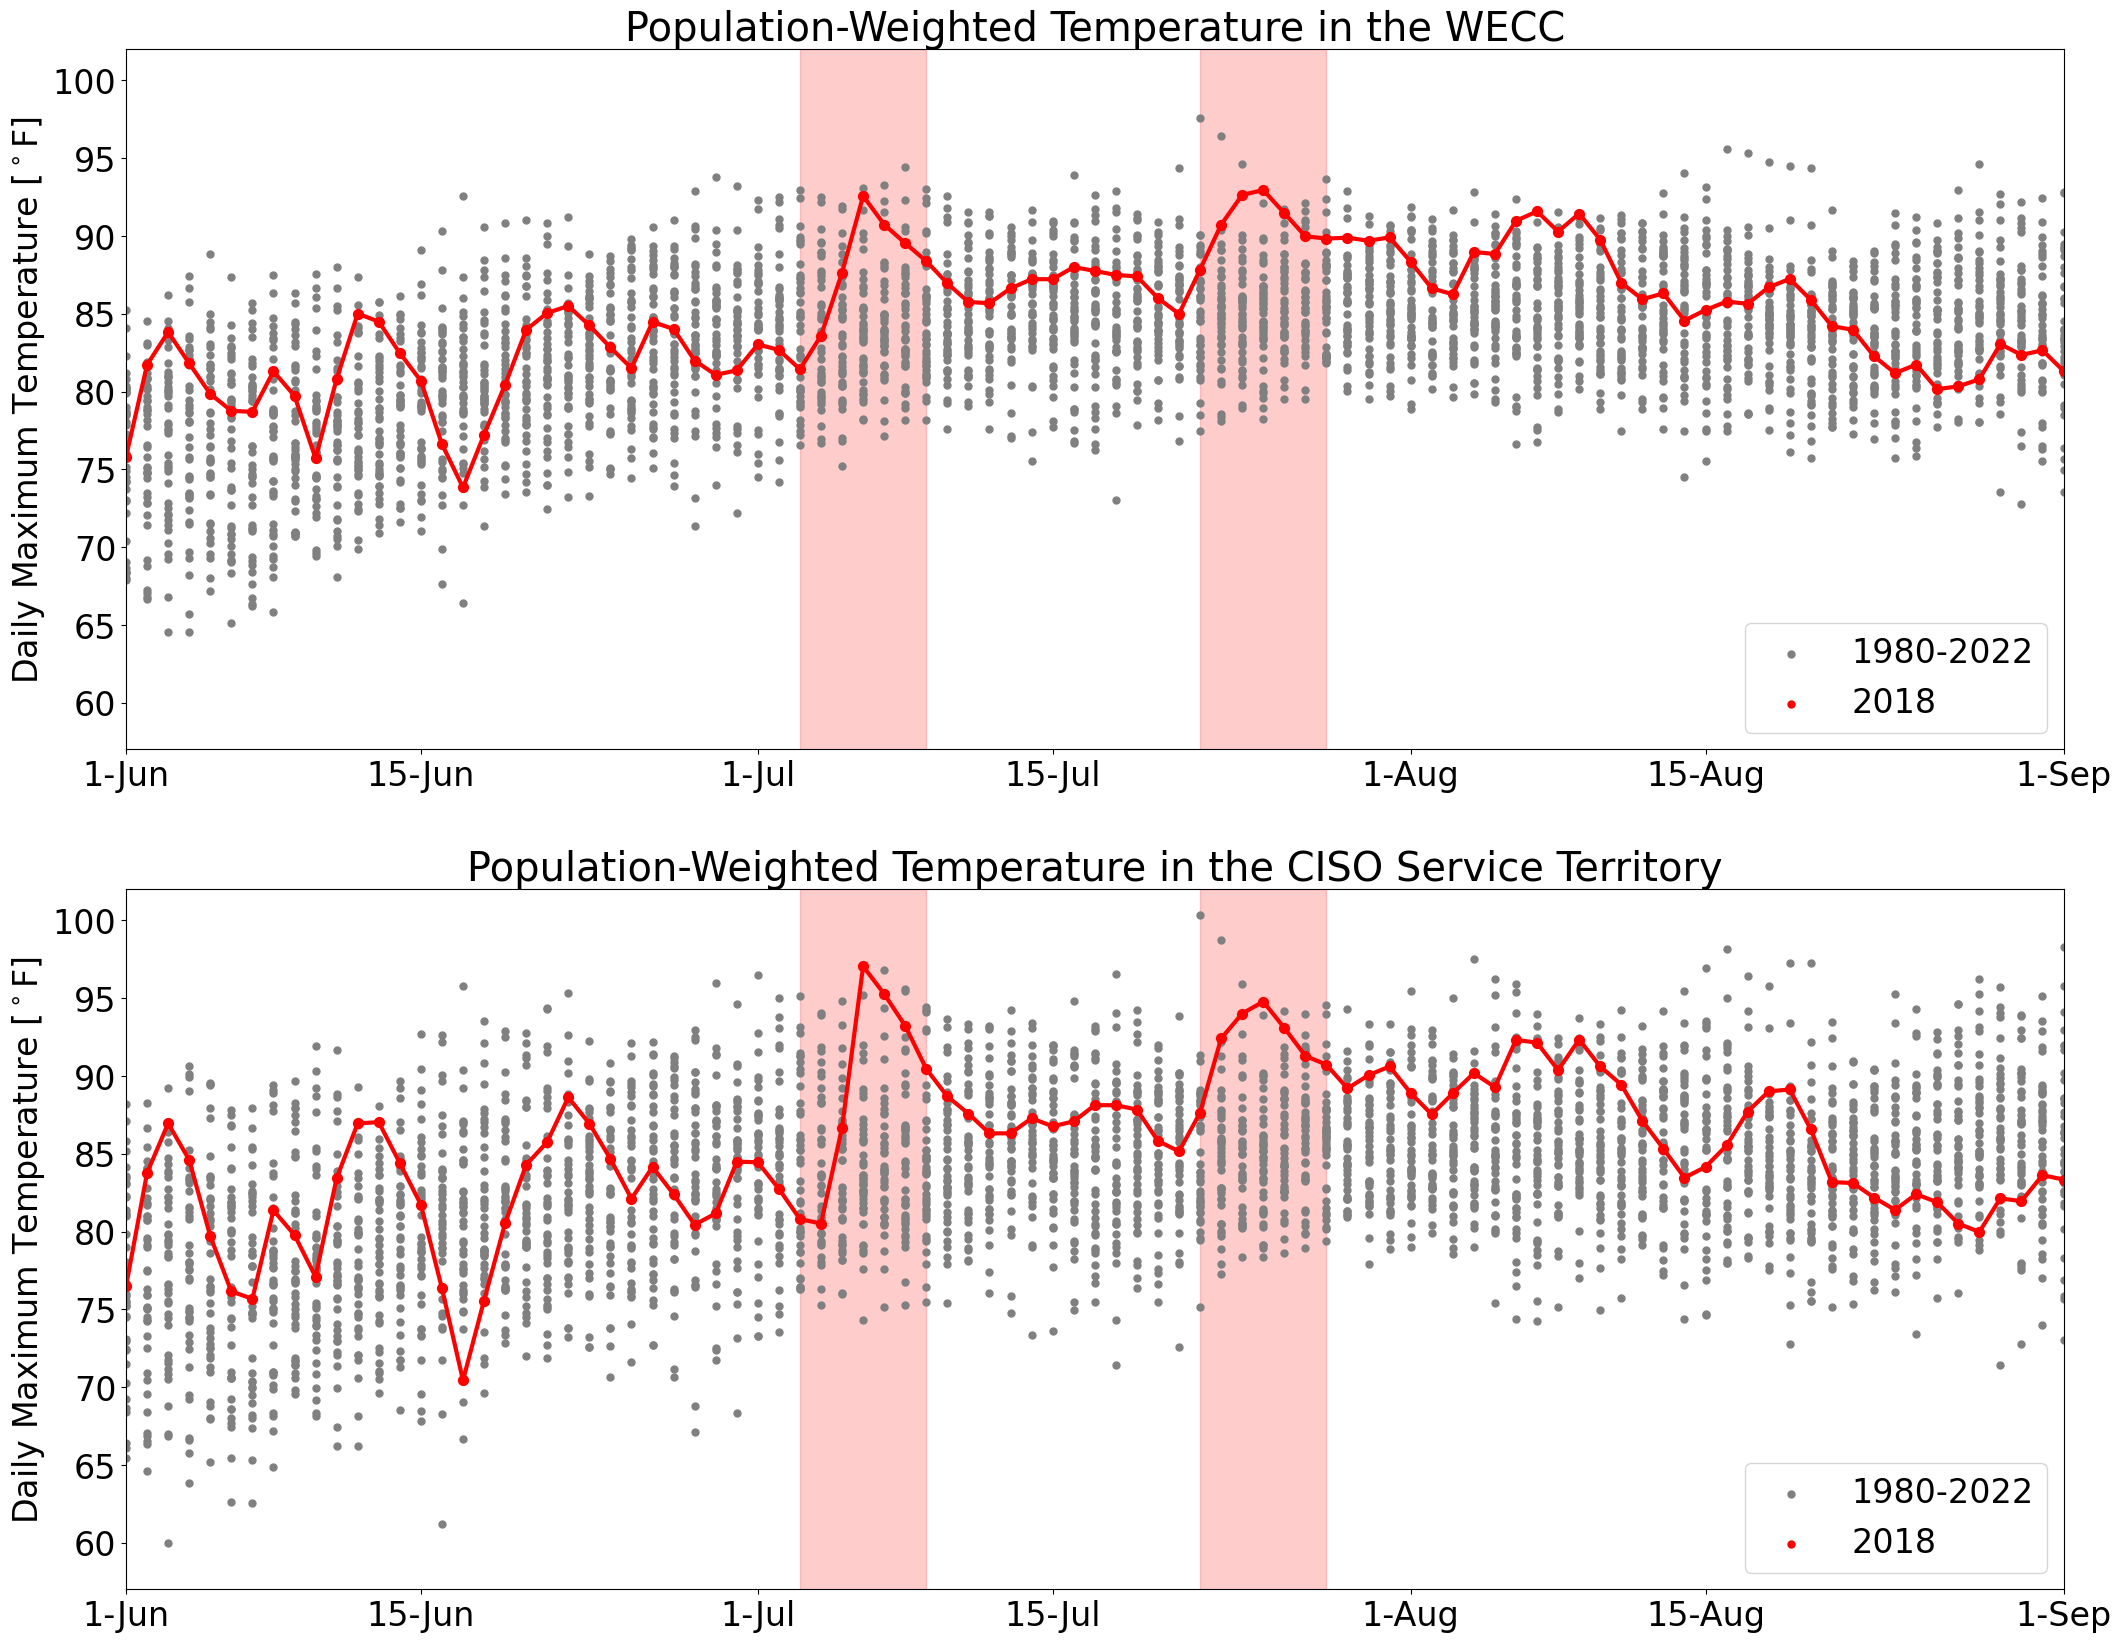

In [60]:
plot_year_temperature_highlight(ba_weather_dir = ba_weather_dir, 
                                ics_weather_dir = ics_weather_dir, 
                                output_dir = output_dir, 
                                ics_to_process = 'WECC',
                                ba_to_plot = 'CISO',
                                year_to_highlight = 2018,
                                image_output_dir = image_output_dir, 
                                image_resolution = 300, 
                                save_images = False)
